In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pingouin as pg
import scipy.stats as stats
import dc_stat_think as dcst

In [50]:
sns.set()
sns.set_style("whitegrid")
np.random.seed(42)

# Heart Failure Data Analysis

In this notebook, we conduct data analysis on the popular [Heart Failure Prediction](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data) dataset from Kaggle. The dataset contains 12 features that can be used to predict mortality by heart failure. As such, successful analysis could shed light on some important insights.

## Context

Contrary to what it may sound like, heart failure does not mean the heart has stopped, and most certainly does not imply sudden death. However, it is a serious condition of the heart that causes it to pump less blood than usual affecting normal body functions. More than 6 million adults have heart failure in the United States alone, and it can also afflict children. Often times, heart failure is caused by other underlying conditions such as coronary artery disease, and high blood pressure. While it has no cure, changes to the lifestyle and directed treatment can help people live longer and better lives. As mentioned above, the main task of this dataset is to predict whether a patient <b>dies</b> from heart failure.

Below we list and explain the features of the dataset, while this is in no way exhaustive it can help in analysis down the line.
- Anemia: A condition in which the blood does not have enough healthy red blood cells, while this is mostly a mild condition, it does cause weakness and disrupts normal routines of individuals.
- Creatinine Phosphokinase: This is an enzyme that's found in various tissues. It's primary function is to catalyze the conversion of creatine to phosphocreatine, which is used as an energy store in tissues. Elevated levels of CPK are often used as a marker of CK-rich tissues such as in a myocardial infarction which is a heart attack.
- Diabetes: This is a condition in which the body's ability to produce or respond to the hormone insulin is impaired, resulting in abnormal metabolism of carbohydrates and elevated levels of glucose in the blood and urine. If the glucose levels are not controlled appropriately, it can lead to the damage of various organs.
- Ejection Fraction: This is a measurement of how much blood the left ventricle pumps out with each contraction. It is used to help classify heart failure and guide treatment. The normal range is between 50% and 70%.
- High Blood Pressure: This is a condition in which the blood pressure of the individual is in an elevated levels. If this isn't controlled it can lead to various complications such as heart disease, stroke, and kidney failure.
- Platelets: These are blood cells that help the body form clots to stop bleeding. If the platelet count is too low, internal bleeding can occur.
- Serum Creatinine: This is a waste product that occurs due to the normal energy producing processes that occur in the muscles. This can be tested to see how well the kidneys are filtering the bloody, higher than normal levels could indicate damage to the kidneys.
- Serum Sodium: This is a measure of how much Sodium is present in the blood. Sodium is an important mineral that is useful for the regulation of fluids and helps balance the pH of the body. Higher or lower values than the normal could indicate a problem in the kidney amongst other things.
- Sex: Gender of patient
- Smoking: Whether the patient smokes or not
- Time: This is the time from the heart failure diagnosis to the patient's death or the end of the follow-up period.
- Death Event: Whether the patient died during the follow-up period

The key aspect to note is that all of these patients have sufferred from heart failure, the task is to predict how many died. The key will be to analyze the data with this mindset.

## Initial Data Exploration

In this section we go over the data to understant a few crucial characteristics:
- Number of samples
- Number of features
- Missing values
- Data types

In [5]:
heart_data_v1 = pd.read_csv('./heart_failure_clinical_records_dataset.csv')
print(heart_data_v1.shape)
heart_data_v1.head()

(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


- This is a relatively smaller dataset, with only 299 samples.
- There are 13 features, with 12 being the input features and 1 being the output feature.


In [6]:
heart_data_v1.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

There appears to be no missing data!

In [7]:
heart_data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


The dataset is entirely composed of integer and float types.
- Some of the features will have to be converted to categorical values.

Before advancing with the data analysis, we will create one new feature - disease. This feature is a sum of the 3 individual diseases - anemia, diabetes, and high blood pressure. Furthermore, we will also rename some columns for ease.

In [53]:
heart_data_v2 = heart_data_v1.copy()
heart_data_v2['disease'] = heart_data_v2['anaemia'] + heart_data_v2['high_blood_pressure'] + heart_data_v2['diabetes']

In [68]:
#copy v2
heart_data_v3 = heart_data_v2.copy()
heart_data_v3 = heart_data_v3.rename(
    columns={
        'DEATH_EVENT':'death',
        'anaemia' : 'anemia',
        'creatinine_phosphokinase' : 'cpk',
        'high_blood_pressure' : 'bp',
    }, 
    )

In [145]:
#convert to categorical
heart_data_v4 = heart_data_v3.copy()
heart_data_v4['death'] = heart_data_v4['death'].astype('category')
heart_data_v4['anemia'] = heart_data_v4['anemia'].astype('category')
heart_data_v4['diabetes'] = heart_data_v4['diabetes'].astype('category')
heart_data_v4['bp'] = heart_data_v4['bp'].astype('category')

In [146]:
disease_map = {
    0: 'no disease',
    1: '1 disease',
    2: '2 diseases',
    3: '3 diseases'
}

heart_data_v4['disease'] = heart_data_v4['disease'].map(disease_map)
# heart_data_v4['disease'] = heart_data_v4['disease'].astype('category')
#convert to categorical with ordear
heart_data_v4['disease'] = pd.Categorical(heart_data_v4['disease'], categories=['no disease', '1 disease', '2 diseases', '3 diseases'], ordered=True)

In [147]:
death_map = {
    0: 'alive',
    1: 'dead'
}

heart_data_v4['death'] = heart_data_v4['death'].map(death_map)
heart_data_v4['death'] = heart_data_v4['death'].astype('category')

In [148]:
gender_map = {
    0: 'female',
    1: 'male'
}

heart_data_v4['sex'] = heart_data_v4['sex'].map(gender_map)
heart_data_v4['sex'] = heart_data_v4['sex'].astype('category')

In [149]:
ind_disease_map = {
    0: 'False',
    1: 'True'
}

heart_data_v4['anemia'] = heart_data_v4['anemia'].map(ind_disease_map)
heart_data_v4['diabetes'] = heart_data_v4['diabetes'].map(ind_disease_map)
heart_data_v4['bp'] = heart_data_v4['bp'].map(ind_disease_map)
#convert to categorical
heart_data_v4['anemia'] = heart_data_v4['anemia'].astype('category')
heart_data_v4['diabetes'] = heart_data_v4['diabetes'].astype('category')
heart_data_v4['bp'] = heart_data_v4['bp'].astype('category')

In [150]:
heart_data_v4.head()

,age,anemia,cpk,diabetes,ejection_fraction,bp,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death,disease
0,75.0,False,582,False,20,True,265000.00,1.9,130,male,0,4,dead,1 disease
1,55.0,False,7861,False,38,False,263358.03,1.1,136,male,0,6,dead,no disease
2,65.0,False,146,False,20,False,162000.00,1.3,129,male,1,7,dead,no disease
3,50.0,True,111,False,20,False,210000.00,1.9,137,male,0,7,dead,1 disease
4,65.0,True,160,True,20,False,327000.00,2.7,116,female,0,8,dead,2 diseases


## Exploratory Data Analysis

In this section we will conduct a deep analysis on the various features of the dataset, this will include summary tables, visualizations, and even statistical tests. We will structure the analysis as follows:
- Univariate Analysis
    - This will help in understanding the distributions of individual features.
- Bivariate Analysis
    - This will hep in understanding the relations between 2 different features. Apart from showing association between the target and other features, this can also shed light on whether some variables are correlated.
- Multivariate Analysis
    - This can provide deeper insights into the data, and can help in understanding more complex relationships.

### Univariate Analysis

In this section we will conduct univariate analysis on the various features of the dataset. To start of we will look at the distribution of the target variable. This can help provide insights on whether the dataset is imbalanced or not.

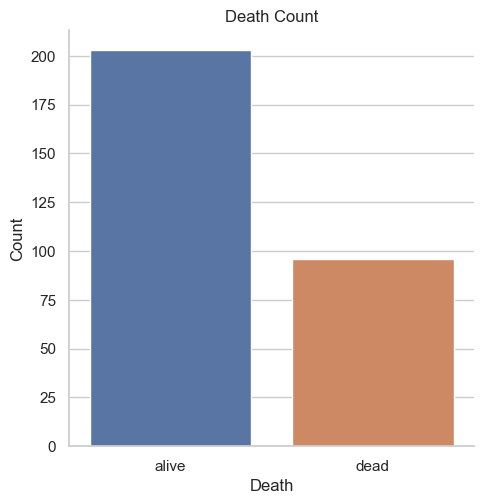

In [31]:
g = sns.catplot(x='death', data=heart_data_v4, kind='count')
g.set(
    xlabel='Death',
    ylabel='Count',
    title='Death Count'
)
plt.show()

The barplot clearly shows the data is imbalanced towards 'alive' samples, with nearly 2/3 of the samples categorized as 'alive'

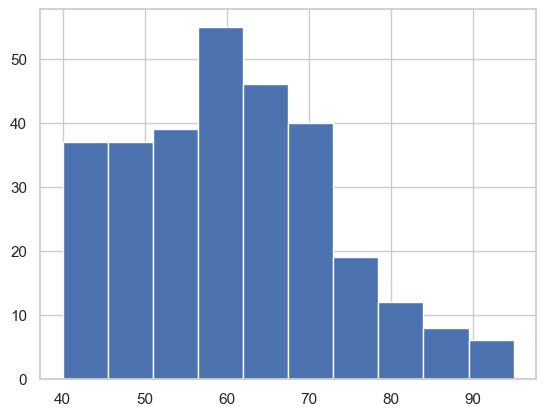

In [49]:
plt.hist(heart_data_v4['age'], bins=10)
plt.show()

Due to the small number of bins, it's difficult to draw conclusions about the distribution of the ages of samples from the histogram, to get a better understanding we will use an ECDF plot. However, the following insights can be drawn from this plot:
- The mean age appears to be around 60 years.
- The data appears to be skewed towards samples of a lower age.

To get a better understanding of the distribution of ages, we will plot a normal distribution plot against the ECDF to visualize the alignment.

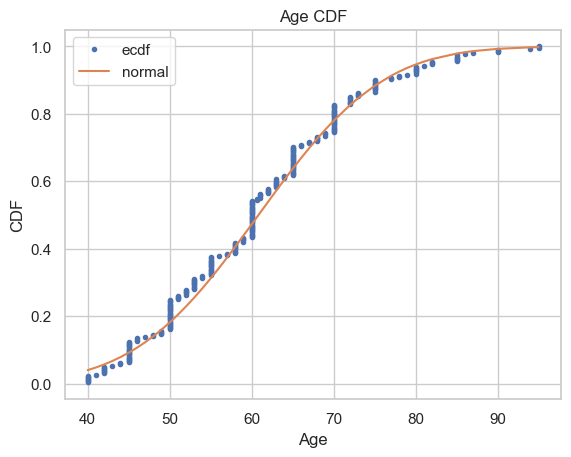

In [51]:
mean_age = heart_data_v4['age'].mean()
std_age = heart_data_v4['age'].std()
normal_samples = np.random.normal(mean_age, std_age, size=10000)

x, y = dcst.ecdf(heart_data_v4['age'])
plt.plot(x, y, marker='.', linestyle='none', label='ecdf')
plt.plot(x, stats.norm.cdf(x, mean_age, std_age), label='normal')

#appropriate labels and title
plt.xlabel('Age')
plt.ylabel('CDF')
plt.title('Age CDF')
plt.legend()
plt.show()

As can be seen, the ages of the samples appear to be normally distributed.

In [98]:
def univatiate_comp(data, cols):
    """
    This function plots numerical columns data in their completeness using a strip plot, and ECDF.

    Args:
        data (DataFrame): DataFrame containing the data
        cols (list): list of columns to plot
    """

    fig, axes = plt.subplots(len(cols), 2, figsize=(10, 5*len(cols)))

    for i, col in enumerate(cols):

        x, y = dcst.ecdf(data[col])

        #swarm plot
        sns.stripplot(y=data[col], jitter=True,ax=axes[i, 0])
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_title(f'{col} swarm plot')

        #ecdf
        axes[i, 1].plot(x, y, marker='.', linestyle='none')
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_ylabel('ECDF')
        axes[i, 1].set_title(f'{col} ECDF')

    plt.tight_layout()
    plt.show()


def univatiate_single(data, col, titles):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    x, y = dcst.ecdf(data[col])

    #swarm plot
    sns.stripplot(y=data[col], jitter=True,ax=ax1)
    ax1.set_xlabel(col)
    ax1.set_title(titles[0])

    #ecdf
    ax2.plot(x, y, marker='.', linestyle='none')
    ax2.set_xlabel(col)
    ax2.set_ylabel('ECDF')
    ax2.set_title(titles[1])

    plt.tight_layout()
    plt.show()
    


In [181]:
cpk = heart_data_v4[['sex', 'cpk']].copy()
cpk.loc[:, 'high'] = False
cpk.loc[(cpk['cpk'] > 334) & (cpk['sex'] == 'male'), 'high'] = True
cpk.loc[(cpk['cpk'] > 176) & (cpk['sex'] == 'female'), 'high'] = True
cpk.head()

,sex,cpk,high
0,male,582,True
1,male,7861,True
2,male,146,False
3,male,111,False
4,female,160,False


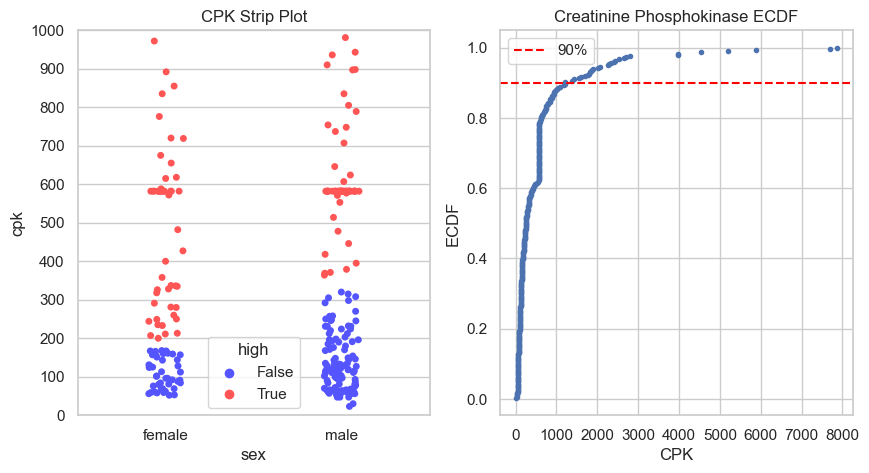

In [188]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

x, y = dcst.ecdf(heart_data_v4['cpk'])
sns.stripplot(x='sex', y='cpk', hue='high', palette='seismic', data=cpk, jitter=True, ax=ax1)
ax1.set_ylim(0, 1000)
ax1.set_title('CPK Strip Plot')
ax1.set_yticks([n for n in range(0, 1001, 100)])

ax2.plot(x, y, marker='.', linestyle='none')
ax2.set_xlabel('CPK')
ax2.set_ylabel('ECDF')
ax2.set_xticks([n for n in range(0, 8001, 1000)])
ax2.set_title('Creatinine Phosphokinase ECDF')
ax2.axhline(0.90, color='red', linestyle='--', label='90%')
ax2.legend()
plt.show()

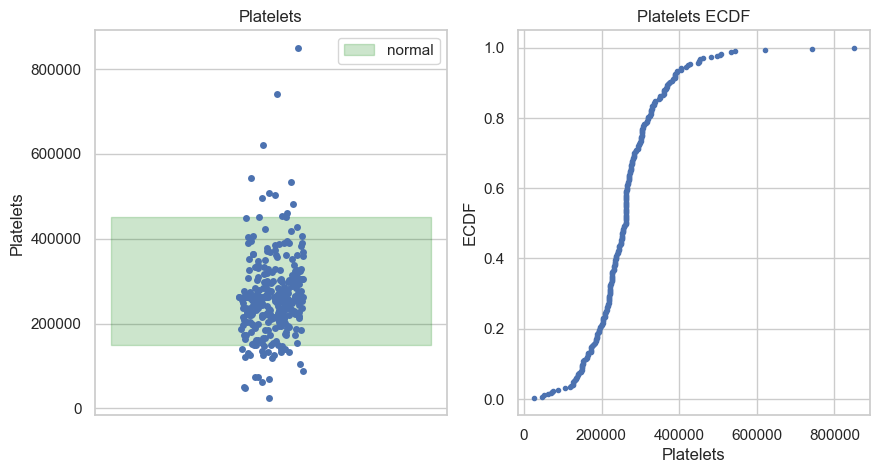

In [190]:
#do same with platelets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

x, y = dcst.ecdf(heart_data_v4['platelets'])

sns.stripplot(y='platelets', data=heart_data_v4, jitter=True, ax=ax1, dodge=True)
ax1.fill_between(ax1.get_xlim(), 150000, 450000, alpha=0.2, color='green', label='normal')
ax1.set_title('Platelets')
ax1.set_ylabel('Platelets')
ax1.legend()

ax2.plot(x, y, marker='.', linestyle='none')
ax2.set_xlabel('Platelets')
ax2.set_ylabel('ECDF')
ax2.set_title('Platelets ECDF')
plt.show()

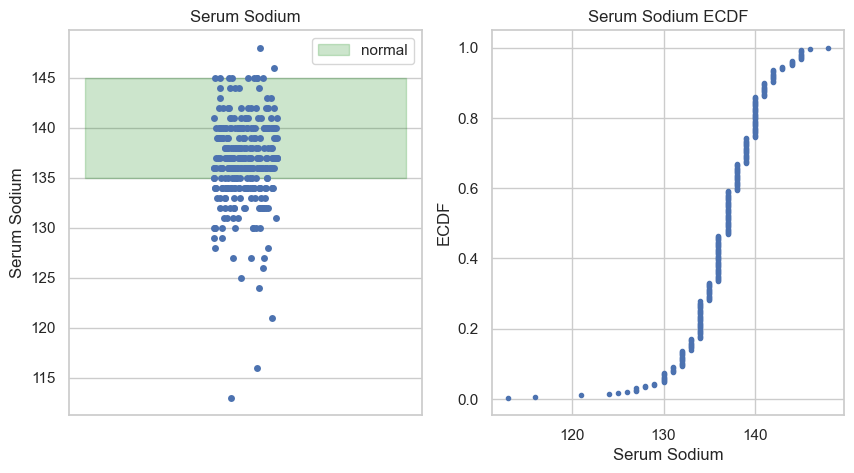

In [140]:
#do same with serum_sodium

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

x, y = dcst.ecdf(heart_data_v4['serum_sodium'])

sns.stripplot(y='serum_sodium', data=heart_data_v4, jitter=True, ax=ax1)
ax1.set_title('Serum Sodium')
ax1.set_ylabel('Serum Sodium')
ax1.fill_between(ax1.get_xlim(), 135, 145, alpha=0.2, color='green', label="normal")
ax1.legend()

ax2.plot(x, y, marker='.', linestyle='none')
ax2.set_xlabel('Serum Sodium')
ax2.set_ylabel('ECDF')
ax2.set_title('Serum Sodium ECDF')
plt.show()

Text(0.5, 1.0, 'Ejection Fraction ECDF')

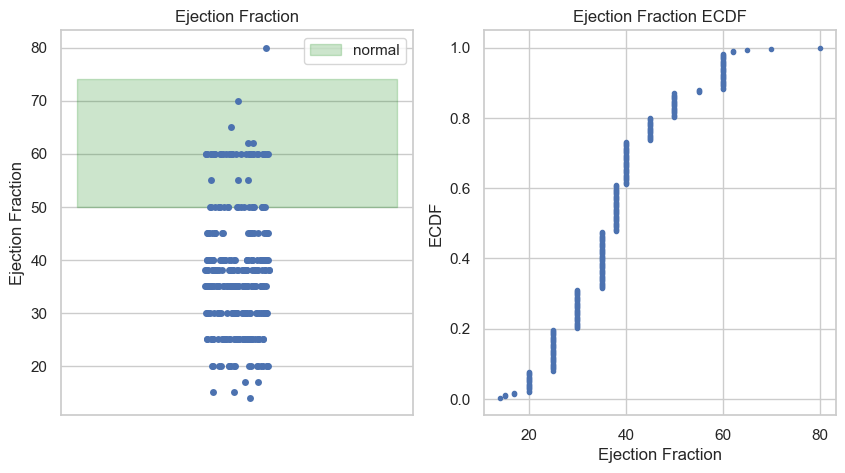

In [135]:
#plot for ejection fraction with fill between 52-74
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

x, y = dcst.ecdf(heart_data_v4['ejection_fraction'])

sns.stripplot(y='ejection_fraction', data=heart_data_v4, jitter=True, ax=ax1)
ax1.set_title('Ejection Fraction')
ax1.set_ylabel('Ejection Fraction')
ax1.fill_between(x=ax1.get_xlim(), y1=50, y2=74, color='green', alpha=0.2, label='normal')
ax1.legend()

ax2.plot(x, y, marker='.', linestyle='none')
ax2.set_xlabel('Ejection Fraction')
ax2.set_ylabel('ECDF')
ax2.set_title('Ejection Fraction ECDF')


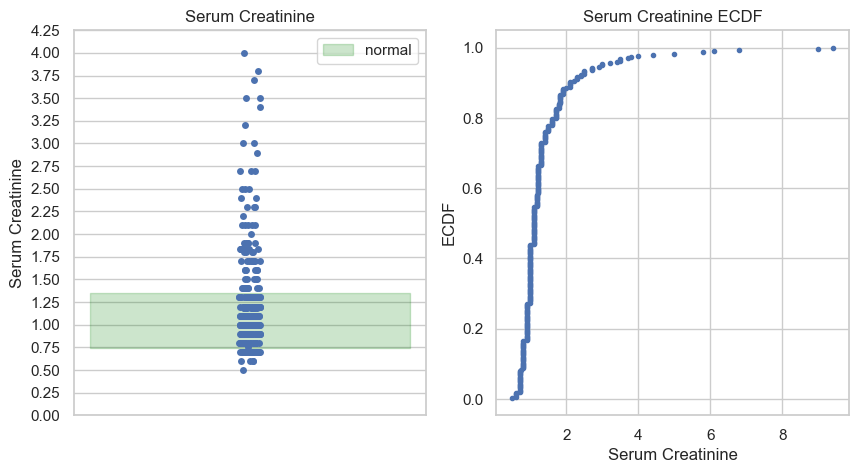

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x, y = dcst.ecdf(heart_data_v4['serum_creatinine'])

sns.stripplot(y='serum_creatinine', data=heart_data_v4, jitter=True, ax=ax[0])
ax[0].set_title('Serum Creatinine')
ax[0].set_ylabel('Serum Creatinine')
ax[0].set_ylim(0, 4)
ax[0].set_yticks(np.arange(0, 4.5, 0.25))
ax[0].fill_between(x=ax[0].get_xlim(), y1=0.74, y2=1.35, color='green', alpha=0.2, label='normal')
ax[0].legend()

ax[1].plot(x, y, marker='.', linestyle='none')
ax[1].set_xlabel('Serum Creatinine')
ax[1].set_ylabel('ECDF')
ax[1].set_title('Serum Creatinine ECDF')

# plt.tight_layout()
plt.show()


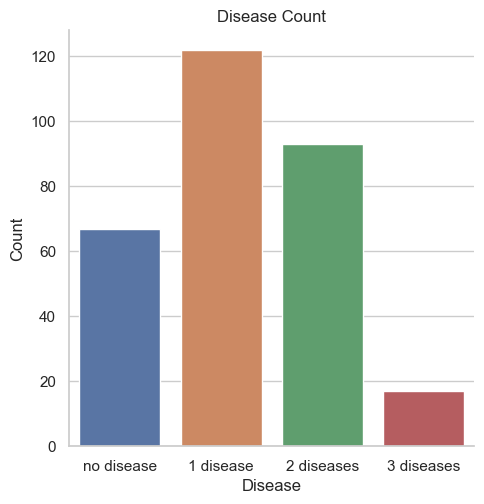

In [121]:
fig = sns.catplot(x='disease', data=heart_data_v4,kind='count')
fig.set(
    xlabel='Disease',
    ylabel='Count',
    title='Disease Count'
)
plt.show()

#### Summary

We performed univariate analysis on the various features of the dataset. This was done with the aim to understand the ranges the data occupy and understand the distribution. By comparing with ranges of normal values with the table below, we can paint the picture of where these patients faired. For features such as the 'CPK' which have differing ranges between genders, we plotted the distributions separetely.

Here is the table with the normal, abnormally low, and abnormally high ranges for the requested parameters:

| Parameter | Normal Range | Abnormally Low | Abnormally High |
| --- | --- | --- | --- |
| Creatinine Phosphokinase (CPK) | Men: 52-336 U/L¹ <br> Women: 38-176 U/L¹ | Below 52 U/L for men and 38 U/L for women¹ | Above 336 U/L for men and 176 U/L for women¹ |
| Platelets | 150,000-450,000 per microliter (mcL) of blood⁶ | Below 150,000 per mcL of blood⁶ | Above 450,000 per mcL of blood⁶ |
| Serum Sodium | 135-145 milliequivalents per liter (mEq/L)[^10^] | Below 135 mEq/L[^10^] | Above 145 mEq/L[^10^] |
| Serum Creatinine | Men: 0.74-1.35 mg/dL¹³ <br> Women: 0.59-1.04 mg/dL¹³ | Below 0.74 mg/dL for men and 0.59 mg/dL for women¹³ | Above 1.35 mg/dL for men and 1.04 mg/dL for women¹³ |
| Ejection Fraction | Men: 52-72%¹⁶ <br> Women: 54-74%¹⁶ | Below 52% for men and 54% for women¹⁶ | Above 72% for men and 74% for women¹⁶ |

- Starting of with the distribution of fatalities to those that survived, we can see that the data is imbalanced towards 'alive' samples, with nearly 2/3 of the samples categorized as 'alive'.
- The median age appears to be around 60 years, and the ages of the patients appears to be normally distributed.
- The first feature we analyze is the `cpk`, this features is an indicator of damage to the muscles of the heart where high levels of this compound can indicate serious damage to the organ.
    - As can be seen in from the ECDF of this feature, a vast majority ~90% of samples are below 1000 mcg/L.
    - Based on the table above this doesn't bode well as the extreme upper range is 336 mcg/L for men.
    - Plotting a stripplot shows that indeed many of the patients have high levels of CPK, both for females and males. To better understand the spread we limit the y-axis to 1000 mcg/L.
    - The stripplot shows that the majority of the patients have high levels of CPK, with a few outliers.
- Analysis of the `platelets` feature shows that the majority of samples are within the range, however, there are a few outliers both below and above.
- Analysis of the `ejection_fraction` feature (another crucial indicator of heart functionality) shows that a vast majority of samples are below the normal range, which suggest significantly weakened hearts.
- Analysis of the `serum_creatinine` feature shows that a large amount of patients have higher levels of this substance, this suggest damage to the kidneys of the patients.
- Analysis of the `serum_sodium` feature shows that a large amount of patients have lower than normal amounts of serum sodium, this also suggests damage to the kidneys of the patients.

Univariate analysis allowed us to understand the condition of the patients upon suffering heart failure, and as demonstrated it can be seen that a vast majority of the patients have suffered significant damage to the heart and kidneys. Now we direct our attention to multi-variate analysis that could shed light on the relationships between the features and mortality.